In [21]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import keplerutils
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.pad_inches'] = 0.05

In [2]:
df = pd.read_csv('final.csv', index_col = 0)

In [3]:
df.head()

,disposition,period,time0bk,impact,duration,depth,prad,teq,insol,model_snr,steff,srad,ra,dec,kepmag,slogg_exp
0,1,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,5455.0,0.927,291.93423,48.141651,15.347,87.095046
1,1,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,5455.0,0.927,291.93423,48.141651,15.347,87.095046
2,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3,5853.0,0.868,297.00482,48.134129,15.436,94.066314
3,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,5805.0,0.791,285.53461,48.285210,15.597,95.966579
4,1,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,6031.0,1.046,288.75488,48.226200,15.509,84.605561


Features sorted by their score:
[(0.2567, 'prad'), (0.2048, 'model_snr'), (0.1122, 'period'), (0.0871, 'impact'), (0.0664, 'duration'), (0.0508, 'teq'), (0.0407, 'depth'), (0.0397, 'insol'), (0.0257, 'time0bk'), (0.024, 'ra'), (0.0234, 'steff'), (0.0214, 'dec'), (0.0169, 'srad'), (0.0168, 'slogg_exp'), (0.0136, 'kepmag')]

In [4]:
df_test = df.drop(labels=['kepmag', 'slogg_exp', 'srad', 'dec', 'steff', 'ra', 'time0bk'], axis=1)

In [5]:
X_train_res2, X_test2, y_train_res2, y_test2 = keplerutils.split_and_upsample(df_test)

In [6]:
X_train_res, X_test, y_train_res, y_test = keplerutils.split_and_upsample(df)

# Compare final models

## Logistic Regression

In [7]:
def logisticCV(X_train, y_train):
    '''
        Performs logistic regression with 5-fold cross validated grid search on training data.
        Prints AUC scores and best parameters.
       ----Parameters----
        X_train_res: SMOTE-resampled features
        y_train_res: SMOTE-resampled response
        '''
    X_train_res, X_test, y_train_res, y_test = keplerutils.split_and_upsample(df)
    
    pipe = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', max_iter=1000))
            
    tuning_params = {'logisticregression__C': [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]}
    
    g = GridSearchCV(pipe, tuning_params, scoring='accuracy', cv=5, n_jobs = -1)
    
    g.fit(X_train, y_train)
    
    y_preds = g.predict(X_test2)
    
    print(classification_report(y_test2, y_preds))
            
    print('Best parameters: ', g.best_params_)
    
    print('Mean ROC grid scores: ', g.cv_results_['mean_test_score'])

## Random Forest

In [8]:
def RFCCV(X_train, y_train):
    '''
        Performs Random Forest Classificiation with 5 fold cross validation on training data.
        Prints ROC and and best parameters.
        ----Parameters----
        X_train_res: SMOTE-resampled features
        y_train_res: SMOTE-resampled response
    '''                
    pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
        
    tuning_params = {'randomforestclassifier__max_depth': [50, 100, 150, 200, 250, 300], 
                     'randomforestclassifier__n_estimators': [50, 100, 150, 200, 250, 300],
                     'randomforestclassifier__max_features': [2, 4, 6, 8]
                    }
    
    g = RandomizedSearchCV(pipe, tuning_params, scoring='recall_micro', cv=5, n_jobs = -1)
    
    g.fit(X_train, y_train)
    
    y_preds = g.predict(X_test2)
    
    print("Features sorted by their score:")
    
    print(sorted(zip(map(lambda x: round(x, 4), g.best_estimator_.steps[1][1].feature_importances_), 
                    df_test.iloc[:, 1:].columns.values), reverse=True))
    
    print(y_preds)
    
    print(classification_report(y_test2, y_preds))
            
    print('Best parameters: ', g.best_params_)
    
    print('Mean ROC grid scores: ', g.cv_results_['mean_test_score'])
    
    return g

## Gradient Boosting

In [9]:
def GBCV(X_train, y_train):
    pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier())
        
    tuning_params = {'gradientboostingclassifier__learning_rate': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
                     'gradientboostingclassifier__max_depth': [50, 100, 150, 200],
                     'gradientboostingclassifier__max_features': [2, 4, 6, 8]}
    
    g = RandomizedSearchCV(pipe, tuning_params, cv=5, scoring='recall_micro')
    
    g.fit(X_train, y_train)
    
    y_preds = g.predict(X_test2)
    
    print(classification_report(y_test2, y_preds))
            
    print('Best parameters: ', g.best_params_)
    
    print('Mean ROC grid scores: ', g.cv_results_['mean_test_score'])

## AdaBoost

In [10]:
def ABCV(X_train, y_train):
    pipe = make_pipeline(StandardScaler(), AdaBoostClassifier())
        
    tuning_params = {'adaboostclassifier__learning_rate': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
                     'adaboostclassifier__n_estimators': [50, 100, 150, 200]}
    
    g = RandomizedSearchCV(pipe, tuning_params, cv=5, scoring='recall_micro')
    
    g.fit(X_train, y_train)
    
    y_preds = g.predict(X_test2)
    
    print(classification_report(y_test2, y_preds))
            
    print('Best parameters: ', g.best_params_)
    
    print('Mean ROC grid scores: ', g.cv_results_['mean_test_score'])

## Comparison of the models

In [11]:
GBCV(X_train_res2, y_train_res2)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1131
           1       0.84      0.91      0.87       572

   micro avg       0.91      0.91      0.91      1703
   macro avg       0.90      0.91      0.90      1703
weighted avg       0.91      0.91      0.91      1703

Best parameters:  {'gradientboostingclassifier__max_features': 2, 'gradientboostingclassifier__max_depth': 100, 'gradientboostingclassifier__learning_rate': 0.001}
Mean ROC grid scores:  [0.89876216 0.93427645 0.93560271 0.93928677 0.90642499 0.93840259
 0.93707633 0.90185676 0.90450928 0.93353964]


In [12]:
import pickle

In [13]:
RFCCV(X_train_res2, y_train_res2)

Features sorted by their score:
[(0.1868, 'model_snr'), (0.1834, 'prad'), (0.1328, 'impact'), (0.1197, 'depth'), (0.1048, 'period'), (0.1029, 'insol'), (0.0889, 'duration'), (0.0806, 'teq')]
[1 1 0 ... 0 1 0]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1131
           1       0.83      0.91      0.87       572

   micro avg       0.91      0.91      0.91      1703
   macro avg       0.89      0.91      0.90      1703
weighted avg       0.91      0.91      0.91      1703

Best parameters:  {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__max_features': 2, 'randomforestclassifier__max_depth': 150}
Mean ROC grid scores:  [0.93427645 0.93442381 0.93191866 0.93692897 0.93663425 0.93383436
 0.933687   0.93545535 0.93280283 0.933687  ]


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'randomforestclassifier__max_depth': [50, 100, 150, 200, 250, 300], 'randomforestclassifier__n_estimators': [50, 100, 150, 200, 250, 300], 'randomforestclassifier__max_features': [2, 4, 6, 8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='recall_micro', verbose=0)

In [14]:
final_model = RFCCV(X_train_res2, y_train_res2)

Features sorted by their score:
[(0.2161, 'prad'), (0.1884, 'model_snr'), (0.124, 'period'), (0.1176, 'impact'), (0.1046, 'depth'), (0.0866, 'teq'), (0.0817, 'duration'), (0.081, 'insol')]
[1 1 0 ... 0 1 0]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1131
           1       0.84      0.91      0.87       572

   micro avg       0.91      0.91      0.91      1703
   macro avg       0.89      0.91      0.90      1703
weighted avg       0.91      0.91      0.91      1703

Best parameters:  {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_features': 2, 'randomforestclassifier__max_depth': 250}
Mean ROC grid scores:  [0.93280283 0.93471854 0.93678161 0.9325081  0.93560271 0.9360448
 0.93442381 0.93530799 0.93457118 0.93530799]


In [15]:
pickle.dump(final_model, open('model.pkl', 'wb'))

In [16]:
logisticCV(X_train_res2, y_train_res2)

              precision    recall  f1-score   support

           0       0.94      0.78      0.85      1131
           1       0.67      0.91      0.77       572

   micro avg       0.82      0.82      0.82      1703
   macro avg       0.81      0.84      0.81      1703
weighted avg       0.85      0.82      0.82      1703

Best parameters:  {'logisticregression__C': 10000000.0}
Mean ROC grid scores:  [0.80047156 0.81948128 0.83436487 0.83790156 0.84040672 0.84541704
 0.84497495 0.84541704 0.8455644  0.84571176]


In [17]:
ABCV(X_train_res2, y_train_res2)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/py

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

              precision    recall  f1-score   support

           0       0.95      0.88      0.92      1131
           1       0.80      0.91      0.85       572

   micro avg       0.89      0.89      0.89      1703
   macro avg       0.88      0.90      0.88      1703
weighted avg       0.90      0.89      0.90      1703

Best parameters:  {'adaboostclassifier__n_estimators': 150, 'adaboostclassifier__learning_rate': 1}
Mean ROC grid scores:  [0.91320365 0.5        0.82950192 0.5        0.27055703 0.90156204
 0.27055703 0.91187739 0.5        0.90598291]


In [18]:
probs = final_model.predict_proba(X_test2)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

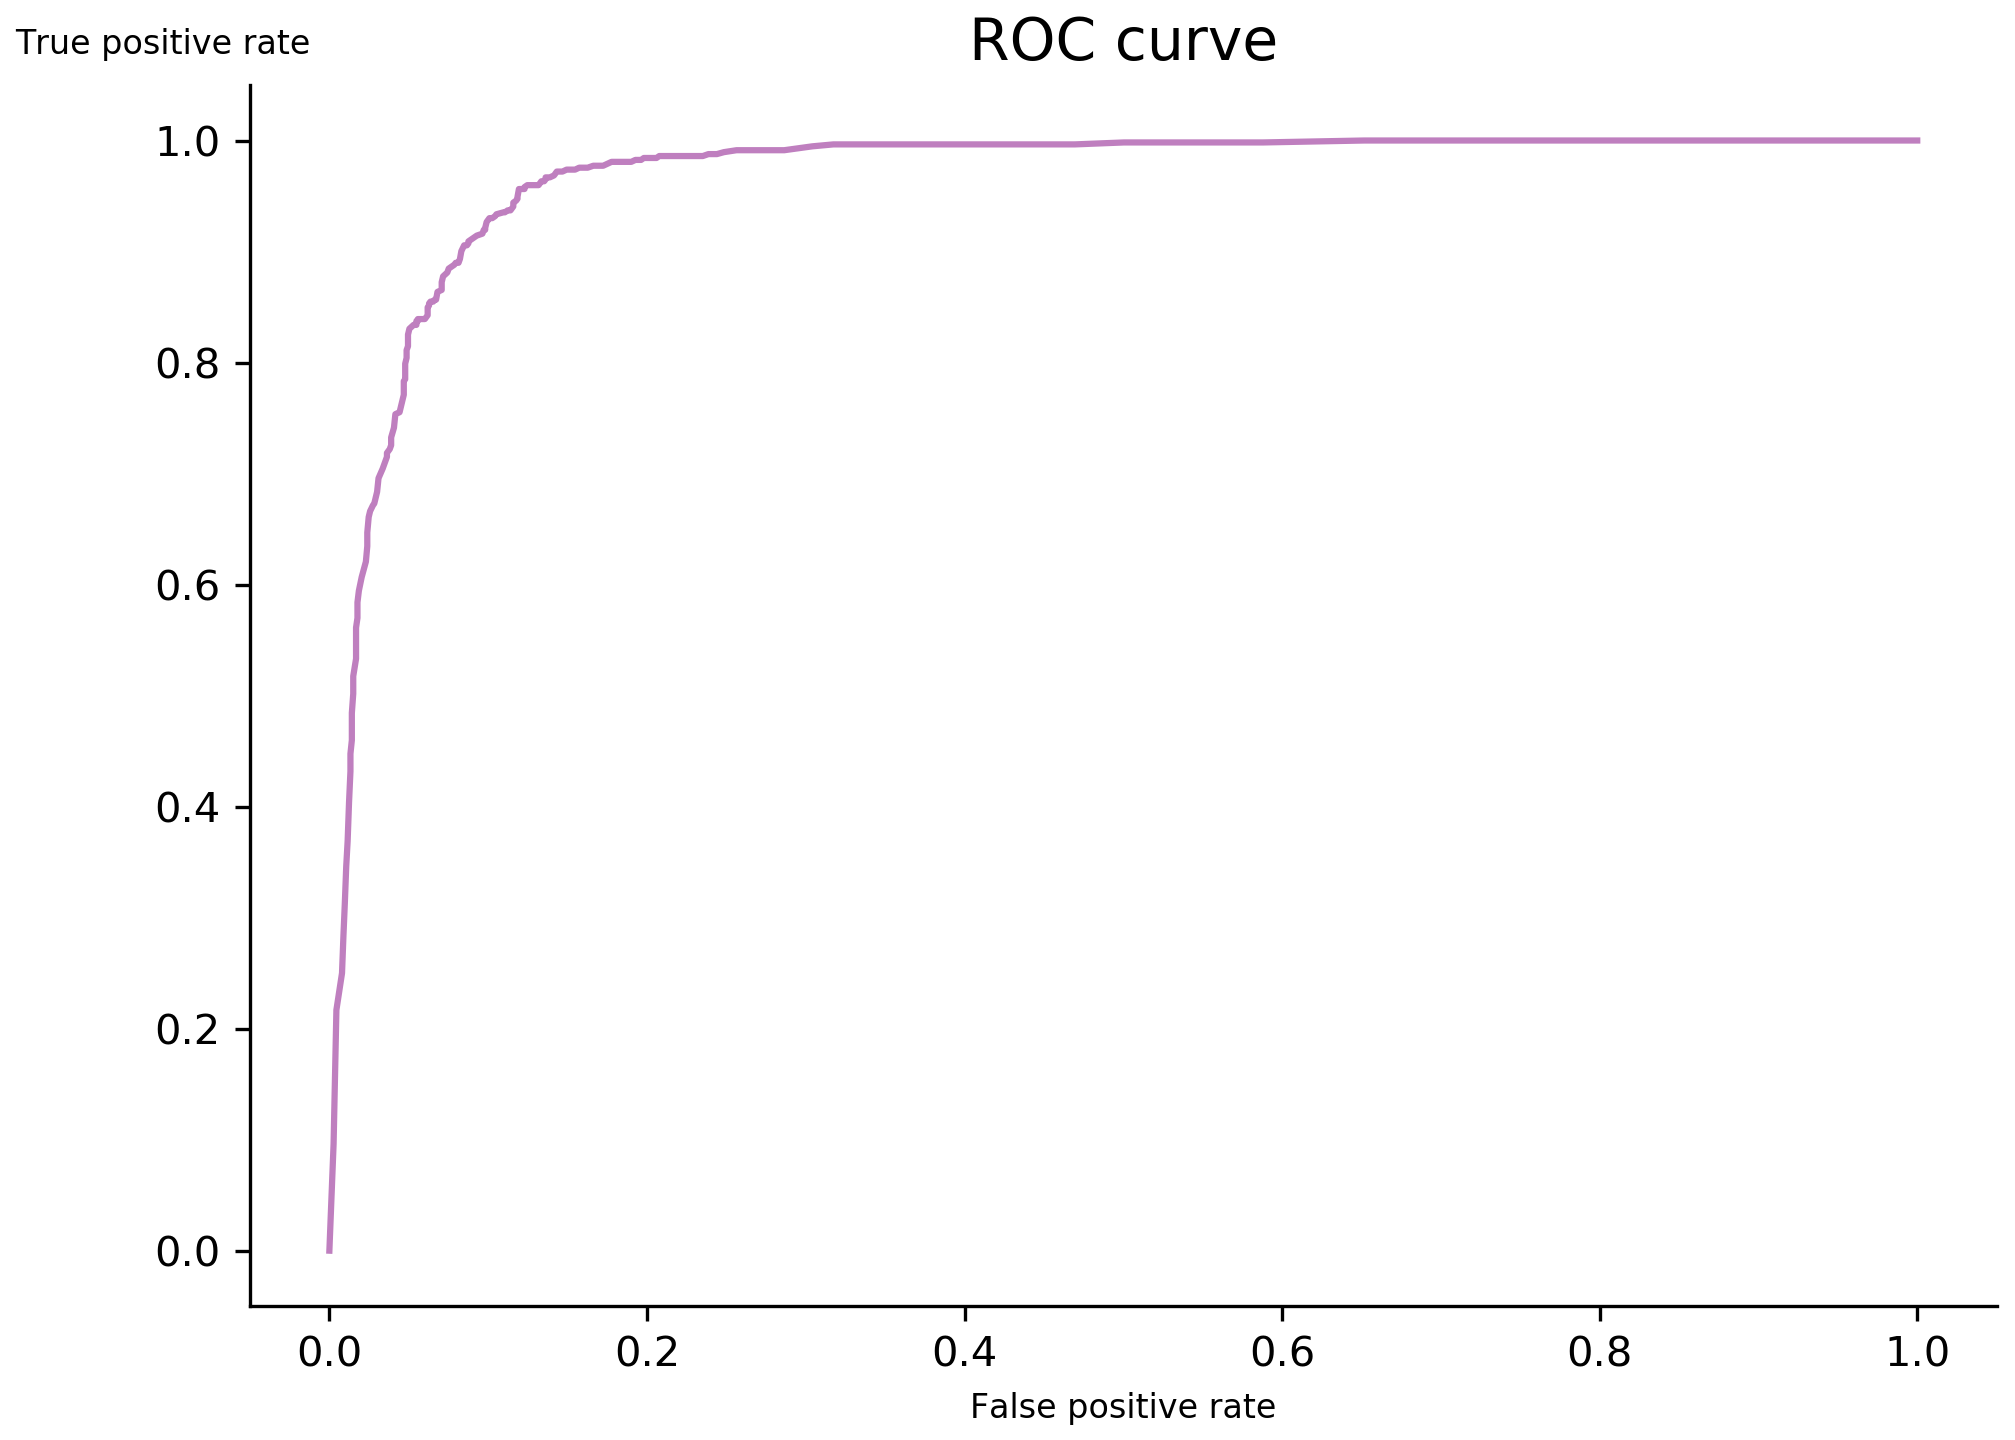

In [50]:
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='purple', alpha = 0.5)
plt.xlabel('False positive rate', size=8)
plt.ylabel('True positive rate', size=8, rotation=0)
plt.title('ROC curve', size=14)
plt.tight_layout()

ax = plt.gca()
ax.yaxis.set_label_coords(-0.05,1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

plt.savefig('ROC_curve.png');